# Fundamentals of ImageJ
This tutorial will educate you on the basic concepts and usage of the ImageJ API.

## The ImageJ gateway

The first step when working with ImageJ is to create an *ImageJ gateway*.  This gateway provides access to ImageJ operations and data structures.  

In [ ]:
// Behind a firewall? Configure your proxy settings here.
//System.setProperty("http.proxyHost","myproxy.domain")
//System.setProperty("http.proxyPort","8080")

//////////////////////////////////////////////////////////////
// Load ImageJ. This may take some minutes the first time   //
// while ImageJ is installed into ~/.groovy/grapes locally. //
//////////////////////////////////////////////////////////////
@GrabResolver(name='imagej', root='http://maven.imagej.net/content/groups/public/')
@Grab('net.imagej:imagej:2.0.0-rc-58')
import net.imagej.ImageJ
ij = new ImageJ()
println("ImageJ is ready to go.")

## Services

ImageJ's functionality is divided into *services*.  Each service provides some API methods for performing related tasks.

The gateway provides easy access to this slew of services. Here are some example service calls:

In [ ]:
// The plugin service manages the available plugins (see "Plugins" below).
pluginCount = ij.plugin().getIndex().size()
println("There are " + pluginCount + " plugins available.")

// The log service is used for logging messages.
ij.log().warn("Ignoring negative sigma value.")

// The status service is used to report the current status of operations.
// Within a notebook like this, the call does not do anything visible.
ij.status().showStatus("Processing data file 34 of 97...")

// The menu service organizes a menu hierarchy for modules (see "Modules" below).
menuItemCount = ij.menu().getMenu().size()
println("There are " + menuItemCount + " menu items total.")

// The platform service handles platform-specific functionality.
// E.g., it can open a URL in the default web browser for your system:
ij.platform().open(new URL("https://imagej.net/"))

### Comparison with ImageJ 1.x
<div style="float: left"><img src="http://imagej.net/_images/a/a8/Imagej1-icon.png" width="48"></div>

[ImageJ 1.x](https://imagej.net/ImageJ1) has a similar concept with the `ij.ImageJ` class, which is created using `new ImageJ()` and cached statically as a singleton.  This allows the ImageJ instance to be recovered later by calling `IJ.getInstance()`, and simplifies the API in some ways.  However, the assumption that there will only ever be one ImageJ per JVM limits its flexibility, and the fact that `ij.ImageJ` extends `java.awt.Frame` makes ImageJ 1.x difficult to use [headless](https://imagej.net/Headless) or with user interfaces other than Java AWT. Furthermore, [ImageJ 1.x](https://imagej.net/ImageJ1) is not service-driven, which makes it less extensible, since additional functionality cannot be registered with the context.

### How to explore the API

One very easy way to explore the API is via an [Integrated Development Environment (IDE)](https://imagej.net/IDEs) such as [Eclipse](https://imagej.net/Eclipse) or [IntelliJ IDEA](https://imagej.net/IDEA). You can use the IDE's autocomplete feature to list all of the available methods of a particular object. E.g., in Eclipse, if you press <kbd>ctrl</kbd>+<kbd>space</kbd> after a period (`.`) character on an object, you will see a list of methods which are available:

<p>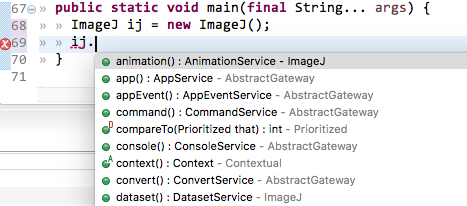</p>

Unfortunately, here in this notebook software, the autocompletion logic is not (yet!) advanced enough to fully offer such a feature. Hence, ImageJ includes a handy method for inspecting an object's methods. Here is an example:

In [ ]:
myList = ["quick", "brown", "fox"]
ij.notebook().methods(myList)

Try it yourself on the ImageJ service of your choice!

### Complete list of built-in services

Here is the complete list of built-in services accessible from the ImageJ gateway:

In [ ]:
ij.notebook().methods(ij).findAll{ it.get("returns").endsWith("Service") }

## Plugins

ImageJ is built on the [SciJava plugin framework](http://imagej.net/SciJava_Common). Essentially everything in ImageJ is a [plugin](http://imagej.net/Plugins).

There are many kinds of plugins, and you can also define your own new kinds. Some of the most central built-in plugin types are:

* `Service` – A collection of related functionality. See "Services" above.
* `Command` – A routine which can be executed. See "Modules" below.
* `IOPlugin` – A plugin for reading and/or writing data to/from external locations. See "Data I/O" below.



### Complete list of built-in plugin types

The `PluginService` provides access to meta-information about available plugins. Here is a count of plugins organized by kind:

In [ ]:
// Gather a count of each kind of plugin.
kindCounts = [:]
ij.plugin().getPlugins().forEach{plugin ->
  kind = plugin.getPluginType().getName()
  // HACK: Report all Op plugin subtypes as simply "Op", to avoid overwhelming the list.
  if (kind.startsWith('net.imagej.ops.Ops') || kind.startsWith('net.imagej.ops.features')) kind = 'net.imagej.ops.Op'
  count = kindCounts.get(kind)
  if (!count) count = 0
  kindCounts.put(kind, count + 1)
}
// Build a table which reports this information nicely.
kinds = []
for (kind in kindCounts.keySet().sort()) {
  kinds.add([
    "package": (kind =~ /^.*\./)[0][0..-2],
    "class": (kind =~ /\.[^\.]*$/)[0][1..-1],
    "count": kindCounts.get(kind)
  ])
}
kinds

## Data I/O

The I/O service provides a generalized API for reading and writing from external sources.

### Loading data

Here is an example invocation which opens an image from a remote URL:

In [ ]:
systemProperties = System.getProperties()
systemProperties.setProperty("http.proxyHost","myproxy.domain")
systemProperties.setProperty("http.proxyPort","8080")

snowflake = ij.io().open("http://imagej.net/images/snowflake.gif")
ij.notebook().display(snowflake)

### Saving data

Similarly, you can use use the I/O service to save data to an external destination:

In [ ]:
destPath = System.getProperty("user.home") + "/Desktop/snowflake.png"
ij.io().save(snowflake, destPath)
println("Saved to '" + destPath + "'; length = " + new File(destPath).length())

## Modules

A SciJava _module_ in an executable snippet of code with _typed inputs and outputs_. You can think of them as <a href="https://en.wikipedia.org/wiki/Subroutine">subroutines</a>, also called _functions_ or _methods_ depending on the programming language.

There are two main flavors of module: _commands_ and _scripts_. A `Command` is a plugin written in Java, whereas a script is written in one of the many available [SciJava scripting languages](https://imagej.net/Scripting). Most users who need to code a module will use a script, because they are simpler to write.

### Scripts

Here is a sample module, written as a script:
```groovy
// @INPUT String name
// @OUTPUT String greeting
// @OUTPUT int length
greeting = "Hello, " + name + "!"
length = name.length()
```
You can write scripts such as the above e.g. into ImageJ's [Script Editor](https://imagej.net/Script_Editor), and then run them directly.

ImageJ (or more precisely: the SciJava script framework) will harvest the input parameters—in this case, the `name` string—from the user in a way appropriate to the execution context. For example, when running from the ImageJ user interface, a [Swing](https://en.wikipedia.org/wiki/Swing_(Java)) dialog box will appear asking the user to type in a name. But when running from the command line, the input values can be passed as arguments to the command line invocation—see the [Scripting Headless](http://imagej.net/Scripting_Headless) page for details. The module outputs—in this case, `greeting` and `length`—will then be displayed to the user in a manner appropriate to the situation: when running graphically, one or more windows will typically pop up; when running from the CLI, output values will be logged to the standard output stream.

The [Script Parameters](http://imagej.net/Script_Parameters) page provides more information about using these parameters in your scripts.

Now let's run this script here in the notebook, and see what happens:

In [ ]:
// Write the script as a string constant, so it can be passed to the script service.
script = """
// @INPUT String name
// @OUTPUT String greeting
// @OUTPUT int length
greeting = "Hello, " + name + "!"
length = name.length()
"""

// Run the script, passing input key/value pairs using a map.
inputs = ["name": System.getProperty("user.name")]
module = ij.script().run("greeting.groovy", script, true, inputs).get();

// Extract the module output values.
println("greeting = " + module.getOutput("greeting"))
println("length   = " + module.getOutput("length"))

### Commands

Here is the same example module, but written as a command:

In [ ]:
// NB: While this is a Groovy cell, the class definition here is valid Java.

import org.scijava.ItemIO;
import org.scijava.command.Command;
import org.scijava.plugin.Parameter;
import org.scijava.plugin.Plugin;

@Plugin(type = Command.class)
public class Hello implements Command {
  
  @Parameter
  private String name;
  
  @Parameter(type = ItemIO.OUTPUT)
  private String greeting;
  
  @Parameter(type = ItemIO.OUTPUT)
  private int length;
  
  @Override
  public void run() {
    greeting = "Hello, " + name + "!";
    length = name.length();
  }
}

// Save a reference to the class, for use in the next cell.
greetingCommand = Hello.class

As you can see, commands are more verbose. But there are advantages to using Java, such as performance, reusability, type safety, and powerful IDE features like autocompletion.

Let's run this command using the command service:

In [ ]:
// Run the command, passing input key/value pairs using a map.
inputs = ["name": "John Jacob Jingleheimer Schmidt"]
module = ij.command().run(greetingCommand, true, inputs).get();

// Extract the module output values.
println("greeting = " + module.getOutput("greeting"))
println("length   = " + module.getOutput("length"))

### Complete list of built-in modules

The `ModuleService` provides access to meta-information about available modules. Here is a list of all modules built in to ImageJ:

In [ ]:
modules = []
ij.module().getModules().forEach{module ->
  location = module.getLocation()
  if (location.endsWith(".jar")) location = (module.getLocation() =~ /\/[^\/]*$/)[0][1..-1]
  modules.add([
    "id": module.getIdentifier(),
    "location": location,
    "version": module.getVersion()
  ])
}
modules

### Further reading

For more information about how to write commands and scripts, see the "Extending ImageJ" tutorial notebooks.

## Ops

The true meat of ImageJ is [ImageJ Ops](https://imagej.net/Ops), a library for reusable image processing. An `Op` plugin is form of `Command`, and therefore a module.

Please proceed to the "Introduction to ImageJ Ops" tutorial notebook for a primer with lots of examples!